In [1]:
import os
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    Conv2D,
    MaxPooling2D,
    Flatten,
    Dense,
    BatchNormalization,
    Dropout,
)
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import os
import glob as gb
import cv2
from tqdm import tqdm
import matplotlib.pyplot as plt

In [2]:
base_dir = "./Images/"
image_size = 150

In [3]:
def read_images_from_directory(folder_path, desc, image_size=150):
    images = []
    labels = []

    for class_name in os.listdir(folder_path):
        class_folder_path = os.path.join(folder_path, class_name)

        if not os.path.isdir(class_folder_path):
            continue

        image_files = gb.glob(os.path.join(class_folder_path, "*.jpg"))

        for image_file in tqdm(image_files, desc=f"{desc} in {class_name}"):
            image = plt.imread(image_file)
            img_resized = cv2.resize(image, (image_size, image_size))
            img_rgb = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
            images.append(img_rgb)
            labels.append(class_name)

    return images, labels

In [4]:
desc = "Processing Images"
images, labels = read_images_from_directory(base_dir, desc)
print(f"Processed {len(images)} images from {len(set(labels))} classes.")

Processing Images in glioma_tumor:   0%|          | 0/4630 [00:00<?, ?it/s]

Processing Images in pituitary_tumor: 100%|██████████| 4504/4504 [00:32<00:00, 136.69it/s]

Processed 18818 images from 4 classes.


In [5]:
import numpy as np
from sklearn.preprocessing import LabelBinarizer

x_data = np.array(images)
lb = LabelBinarizer()
y_data = lb.fit_transform(labels)
print(y_data)

[[1 0 0 0]
 [1 0 0 0]
 [1 0 0 0]
 ...
 [0 0 0 1]
 [0 0 0 1]
 [0 0 0 1]]


In [6]:
from sklearn.model_selection import train_test_split

x_temp, x_test, y_temp, y_test = train_test_split(
    x_data, y_data, test_size=0.2, random_state=42
)

x_train, x_val, y_train, y_val = train_test_split(
    x_temp, y_temp, test_size=0.25, random_state=42
)

In [7]:
def create_model():
    model = Sequential()

    model.add(
        Conv2D(64, (3, 3), activation="relu", input_shape=(image_size, image_size, 3))
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))
    model.add(Dense(4, activation="softmax"))

    return model

In [8]:
# Instantiate the model
model = create_model()

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 74, 74, 64)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 74, 74, 64)       256       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 36, 36, 128)      0         
 2D)                                                             
                                                        

In [10]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [11]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=earlystop,
)

Epoch 1/50
353/353 [==============================] - 35s 76ms/step - loss: 3.0873 - accuracy: 0.4266 - val_loss: 1.1729 - val_accuracy: 0.4687
Epoch 2/50
353/353 [==============================] - 25s 70ms/step - loss: 1.0960 - accuracy: 0.5418 - val_loss: 1.8845 - val_accuracy: 0.2883
Epoch 3/50
353/353 [==============================] - 24s 68ms/step - loss: 0.9294 - accuracy: 0.6085 - val_loss: 1.7187 - val_accuracy: 0.2766
Epoch 4/50
353/353 [==============================] - 25s 70ms/step - loss: 0.8412 - accuracy: 0.6597 - val_loss: 0.7987 - val_accuracy: 0.6583
Epoch 5/50
353/353 [==============================] - 24s 69ms/step - loss: 0.7184 - accuracy: 0.7142 - val_loss: 0.9855 - val_accuracy: 0.6137
Epoch 6/50
353/353 [==============================] - 24s 69ms/step - loss: 0.6284 - accuracy: 0.7613 - val_loss: 0.8324 - val_accuracy: 0.6552
Epoch 7/50
353/353 [==============================] - 24s 69ms/step - loss: 0.5506 - accuracy: 0.7878 - val_loss: 0.5526 - val_accuracy:

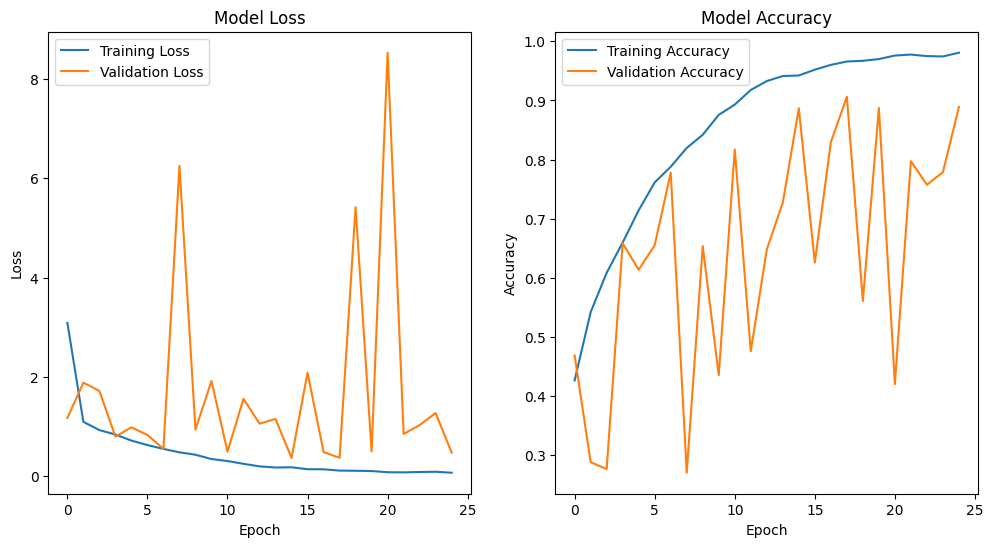

In [12]:
plt.figure(figsize=(12, 6))

plt.subplot(1, 2, 1)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Model Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

In [23]:
import numpy as np


def plot_training_curves(history):
    loss = np.array(history.history["loss"])
    val_loss = np.array(history.history["val_loss"])

    accuracy = np.array(history.history["accuracy"])
    val_accuracy = np.array(history.history["val_accuracy"])

    epochs = range(len(history.history["loss"]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot loss
    ax1.plot(epochs, loss, label="traing_loss", marker="o")

    ax1.plot(epochs, val_loss, label="val_loss", marker="o")

    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss > val_loss),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss < val_loss),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax1.set_title("Loss", fontsize=16)
    ax1.set_xlabel("Epochs", fontsize=10)

    ax1.legend()

    # plot Accuracy
    ax2.plot(epochs, accuracy, label="traing_accuracy", marker="o")

    ax2.plot(epochs, val_accuracy, label="val_accuracy", marker="o")

    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy > val_accuracy),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy < val_accuracy),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax2.set_title("Accuracy", fontsize=16)
    ax2.set_xlabel("Epochs", fontsize=10)

    ax2.legend()

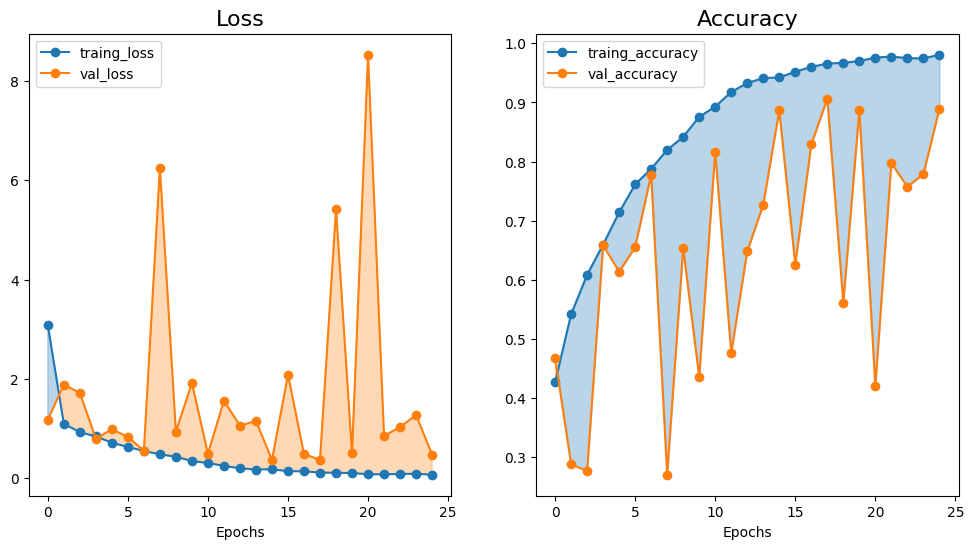

In [24]:
plot_training_curves(history)

In [13]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 3s 21ms/step - loss: 0.3336 - accuracy: 0.8974
Test accuracy: 0.8974494934082031
Test loss: 0.333616703748703


In [14]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 3s 19ms/step


In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [16]:
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Accuracy: 0.8974495217853348
Precision: 0.9031534982484427
Recall: 0.8974495217853348
F1 Score: 0.8973641815816356


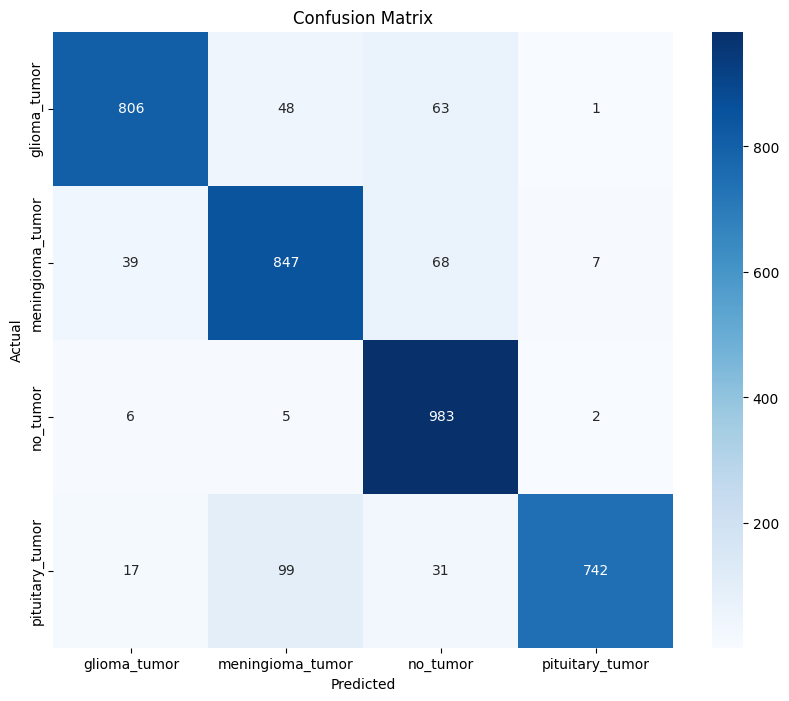

In [17]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "Custom_CNN(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\Custom_CNN(150x150).h5


In [25]:
def create_model():
    model = Sequential()

    model.add(
        Conv2D(32, (3, 3), activation="relu", input_shape=(image_size, image_size, 3))
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation="softmax"))

    return model

In [26]:
# Instantiate the model
model = create_model()

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 32)      896       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 74, 74, 32)       0         
 2D)                                                             
                                                                 
 batch_normalization_4 (Batc  (None, 74, 74, 32)       128       
 hNormalization)                                                 
                                                                 
 conv2d_5 (Conv2D)           (None, 72, 72, 64)        18496     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 36, 36, 64)       0         
 2D)                                                             
                                                      

In [28]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [29]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=earlystop,
)

Epoch 1/50
353/353 [==============================] - 22s 55ms/step - loss: 1.8067 - accuracy: 0.4759 - val_loss: 0.9833 - val_accuracy: 0.5962
Epoch 2/50
353/353 [==============================] - 16s 46ms/step - loss: 0.9470 - accuracy: 0.6168 - val_loss: 1.7920 - val_accuracy: 0.3985
Epoch 3/50
353/353 [==============================] - 16s 44ms/step - loss: 0.7594 - accuracy: 0.6982 - val_loss: 3.1665 - val_accuracy: 0.2877
Epoch 4/50
353/353 [==============================] - 16s 45ms/step - loss: 0.6140 - accuracy: 0.7709 - val_loss: 0.6836 - val_accuracy: 0.7524
Epoch 5/50
353/353 [==============================] - 16s 45ms/step - loss: 0.4995 - accuracy: 0.8143 - val_loss: 1.3590 - val_accuracy: 0.5526
Epoch 6/50
353/353 [==============================] - 14s 41ms/step - loss: 0.4404 - accuracy: 0.8393 - val_loss: 0.5883 - val_accuracy: 0.7612
Epoch 7/50
353/353 [==============================] - 13s 37ms/step - loss: 0.3588 - accuracy: 0.8717 - val_loss: 0.3987 - val_accuracy:

In [30]:
import numpy as np


def plot_training_curves(history):
    loss = np.array(history.history["loss"])
    val_loss = np.array(history.history["val_loss"])

    accuracy = np.array(history.history["accuracy"])
    val_accuracy = np.array(history.history["val_accuracy"])

    epochs = range(len(history.history["loss"]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot loss
    ax1.plot(epochs, loss, label="traing_loss", marker="o")

    ax1.plot(epochs, val_loss, label="val_loss", marker="o")

    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss > val_loss),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss < val_loss),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax1.set_title("Loss", fontsize=16)
    ax1.set_xlabel("Epochs", fontsize=10)

    ax1.legend()

    # plot Accuracy
    ax2.plot(epochs, accuracy, label="traing_accuracy", marker="o")

    ax2.plot(epochs, val_accuracy, label="val_accuracy", marker="o")

    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy > val_accuracy),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy < val_accuracy),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax2.set_title("Accuracy", fontsize=16)
    ax2.set_xlabel("Epochs", fontsize=10)

    ax2.legend()

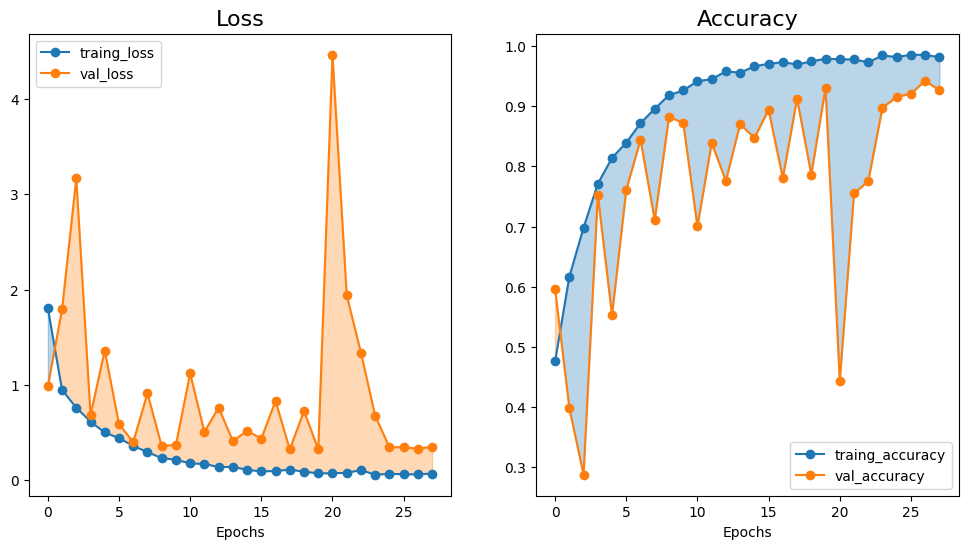

In [31]:
plot_training_curves(history)

In [32]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 2s 17ms/step - loss: 0.3547 - accuracy: 0.9150
Test accuracy: 0.9149840474128723
Test loss: 0.3546699285507202


In [33]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 2s 10ms/step


In [34]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [35]:
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Accuracy: 0.9149840595111584
Precision: 0.9184955473280856
Recall: 0.9149840595111584
F1 Score: 0.9131501014710858


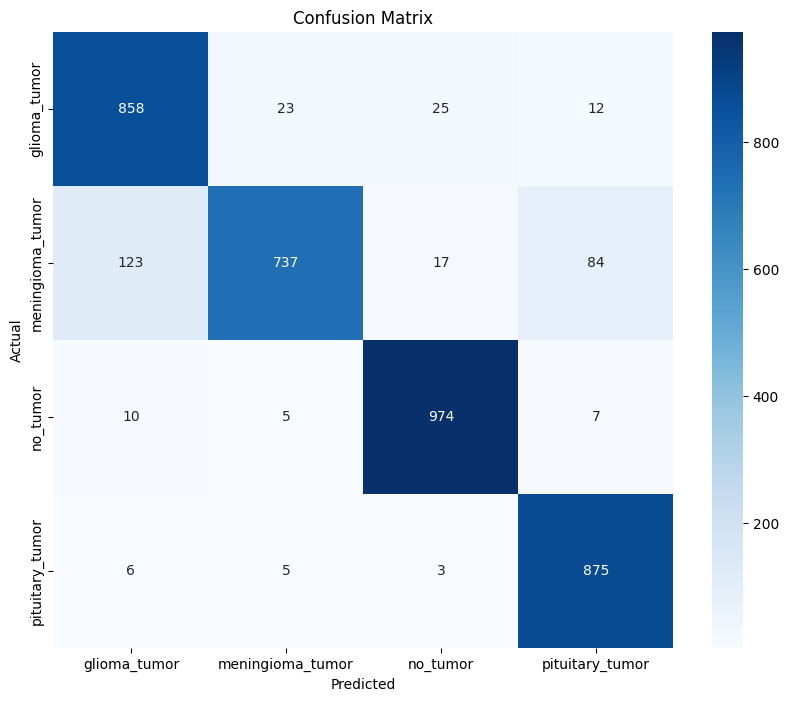

In [36]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [37]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "Custom_CNN_01(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\Custom_CNN_01(150x150).h5


In [51]:
def create_model():
    model = Sequential()

    model.add(
        Conv2D(64, (3, 3), activation="relu", input_shape=(image_size, image_size, 3))
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(512, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.3))
    model.add(Dense(4, activation="softmax"))

    return model

In [52]:
# Instantiate the model
model = create_model()

# Compile the model
model.compile(
    optimizer="adam",
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

In [53]:
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 148, 148, 64)      1792      
                                                                 
 max_pooling2d_12 (MaxPoolin  (None, 74, 74, 64)       0         
 g2D)                                                            
                                                                 
 conv2d_13 (Conv2D)          (None, 72, 72, 128)       73856     
                                                                 
 max_pooling2d_13 (MaxPoolin  (None, 36, 36, 128)      0         
 g2D)                                                            
                                                                 
 conv2d_14 (Conv2D)          (None, 34, 34, 256)       295168    
                                                                 
 max_pooling2d_14 (MaxPoolin  (None, 17, 17, 256)     

In [54]:
from tensorflow.keras.callbacks import EarlyStopping

earlystop = EarlyStopping(
    monitor="val_loss", min_delta=0, patience=10, verbose=1, restore_best_weights=True
)

In [55]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=earlystop,
)

Epoch 1/50
353/353 [==============================] - 41s 112ms/step - loss: 2.1197 - accuracy: 0.4005 - val_loss: 1.0727 - val_accuracy: 0.5228
Epoch 2/50
353/353 [==============================] - 38s 108ms/step - loss: 1.0244 - accuracy: 0.5580 - val_loss: 0.9290 - val_accuracy: 0.6012
Epoch 3/50
353/353 [==============================] - 35s 98ms/step - loss: 0.8782 - accuracy: 0.6337 - val_loss: 0.7636 - val_accuracy: 0.6777
Epoch 4/50
353/353 [==============================] - 30s 86ms/step - loss: 0.7343 - accuracy: 0.7007 - val_loss: 0.6857 - val_accuracy: 0.7163
Epoch 5/50
353/353 [==============================] - 30s 86ms/step - loss: 0.6492 - accuracy: 0.7359 - val_loss: 0.6457 - val_accuracy: 0.7333
Epoch 6/50
353/353 [==============================] - 31s 87ms/step - loss: 0.5571 - accuracy: 0.7833 - val_loss: 0.5678 - val_accuracy: 0.7776
Epoch 7/50
353/353 [==============================] - 31s 88ms/step - loss: 0.5008 - accuracy: 0.8061 - val_loss: 0.5312 - val_accurac

In [56]:
import numpy as np


def plot_training_curves(history):
    loss = np.array(history.history["loss"])
    val_loss = np.array(history.history["val_loss"])

    accuracy = np.array(history.history["accuracy"])
    val_accuracy = np.array(history.history["val_accuracy"])

    epochs = range(len(history.history["loss"]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot loss
    ax1.plot(epochs, loss, label="traing_loss", marker="o")

    ax1.plot(epochs, val_loss, label="val_loss", marker="o")

    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss > val_loss),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss < val_loss),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax1.set_title("Loss", fontsize=16)
    ax1.set_xlabel("Epochs", fontsize=10)

    ax1.legend()

    # plot Accuracy
    ax2.plot(epochs, accuracy, label="traing_accuracy", marker="o")

    ax2.plot(epochs, val_accuracy, label="val_accuracy", marker="o")

    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy > val_accuracy),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy < val_accuracy),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax2.set_title("Accuracy", fontsize=16)
    ax2.set_xlabel("Epochs", fontsize=10)

    ax2.legend()

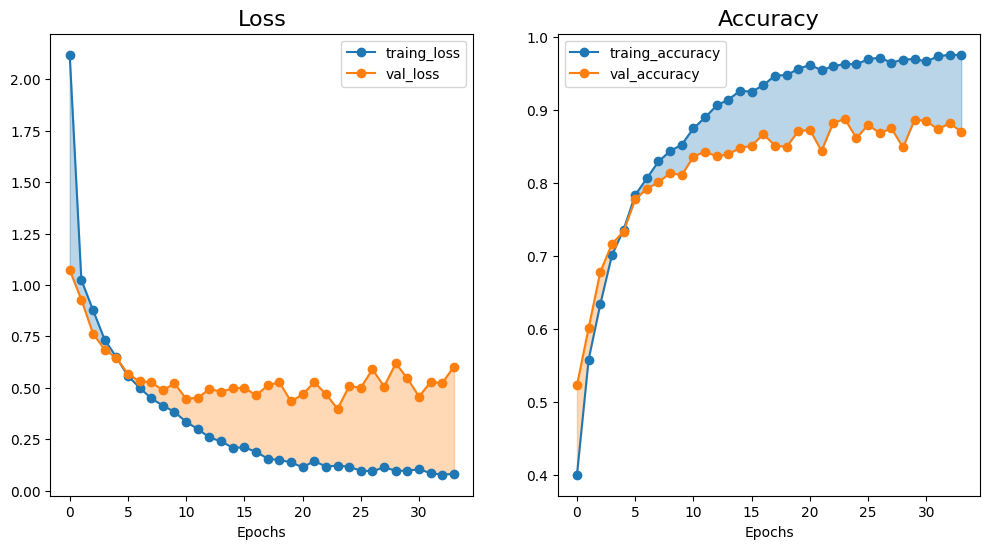

In [57]:
plot_training_curves(history)

In [58]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 5s 46ms/step - loss: 0.4625 - accuracy: 0.8839
Test accuracy: 0.8839001059532166
Test loss: 0.4624992609024048


In [59]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 5s 41ms/step


In [60]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

conf_matrix = confusion_matrix(y_true, y_pred)

accuracy = accuracy_score(y_true, y_pred)


precision = precision_score(y_true, y_pred, average="weighted")


recall = recall_score(y_true, y_pred, average="weighted")


f1 = f1_score(y_true, y_pred, average="weighted")

In [61]:
print(f"Accuracy: {accuracy}")

print(f"Precision: {precision}")

print(f"Recall: {recall}")

print(f"F1 Score: {f1}")

Accuracy: 0.8839001062699257
Precision: 0.8833372169292872
Recall: 0.8839001062699257
F1 Score: 0.8832470688859443


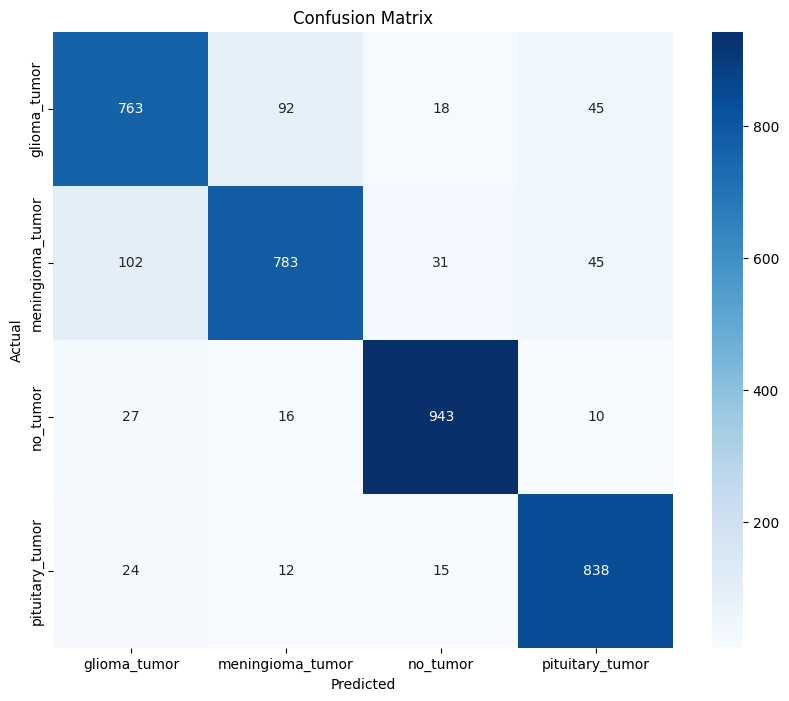

In [62]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [63]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "Custom_CNN_02(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\Custom_CNN_02(150x150).h5


In [7]:
def create_model():
    model = Sequential()

    model.add(
        Conv2D(32, (3, 3), activation="relu", input_shape=(image_size, image_size, 3))
    )
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(64, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(128, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Conv2D(256, (3, 3), activation="relu"))
    model.add(MaxPooling2D((2, 2)))
    model.add(BatchNormalization())

    model.add(Flatten())
    model.add(Dense(512, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(256, activation="relu"))
    model.add(Dropout(0.5))

    model.add(Dense(4, activation="softmax"))

    return model

In [8]:
model = create_model()
optimizer = Adam(learning_rate=0.0001)

model.compile(
    optimizer=optimizer, loss="categorical_crossentropy", metrics=["accuracy"]
)

In [9]:
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping

reduce_lr = ReduceLROnPlateau(
    monitor="val_loss", factor=0.2, patience=3, min_lr=1e-7, verbose=1
)
early_stopping = EarlyStopping(
    monitor="val_loss", patience=10, restore_best_weights=True, verbose=1
)

In [10]:
history = model.fit(
    x_train,
    y_train,
    validation_data=(x_val, y_val),
    epochs=50,
    batch_size=32,
    callbacks=[reduce_lr, early_stopping],
)

Epoch 1/50
353/353 [==============================] - 20s 35ms/step - loss: 1.3685 - accuracy: 0.4988 - val_loss: 0.8055 - val_accuracy: 0.6931 - lr: 1.0000e-04
Epoch 2/50
353/353 [==============================] - 11s 31ms/step - loss: 0.8681 - accuracy: 0.6676 - val_loss: 0.6274 - val_accuracy: 0.7784 - lr: 1.0000e-04
Epoch 3/50
353/353 [==============================] - 11s 31ms/step - loss: 0.6300 - accuracy: 0.7623 - val_loss: 0.5160 - val_accuracy: 0.8061 - lr: 1.0000e-04
Epoch 4/50
353/353 [==============================] - 11s 31ms/step - loss: 0.4927 - accuracy: 0.8174 - val_loss: 0.5430 - val_accuracy: 0.8084 - lr: 1.0000e-04
Epoch 5/50
353/353 [==============================] - 11s 31ms/step - loss: 0.3770 - accuracy: 0.8600 - val_loss: 0.3513 - val_accuracy: 0.8693 - lr: 1.0000e-04
Epoch 6/50
353/353 [==============================] - 11s 31ms/step - loss: 0.2788 - accuracy: 0.8974 - val_loss: 0.3850 - val_accuracy: 0.8653 - lr: 1.0000e-04
Epoch 7/50
353/353 [==============

In [11]:
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test accuracy: {test_acc}")
print(f"Test loss: {test_loss}")

118/118 [==============================] - 1s 11ms/step - loss: 0.2821 - accuracy: 0.9230
Test accuracy: 0.9229543209075928
Test loss: 0.282101035118103


In [12]:
import numpy as np


def plot_training_curves(history):
    loss = np.array(history.history["loss"])
    val_loss = np.array(history.history["val_loss"])

    accuracy = np.array(history.history["accuracy"])
    val_accuracy = np.array(history.history["val_accuracy"])

    epochs = range(len(history.history["loss"]))

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))

    # plot loss
    ax1.plot(epochs, loss, label="traing_loss", marker="o")

    ax1.plot(epochs, val_loss, label="val_loss", marker="o")

    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss > val_loss),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax1.fill_between(
        epochs,
        loss,
        val_loss,
        where=(loss < val_loss),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax1.set_title("Loss", fontsize=16)
    ax1.set_xlabel("Epochs", fontsize=10)

    ax1.legend()

    # plot Accuracy
    ax2.plot(epochs, accuracy, label="traing_accuracy", marker="o")

    ax2.plot(epochs, val_accuracy, label="val_accuracy", marker="o")

    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy > val_accuracy),
        color="C0",
        alpha=0.3,
        interpolate=True,
    )
    ax2.fill_between(
        epochs,
        accuracy,
        val_accuracy,
        where=(accuracy < val_accuracy),
        color="C1",
        alpha=0.3,
        interpolate=True,
    )

    ax2.set_title("Accuracy", fontsize=16)
    ax2.set_xlabel("Epochs", fontsize=10)

    ax2.legend()

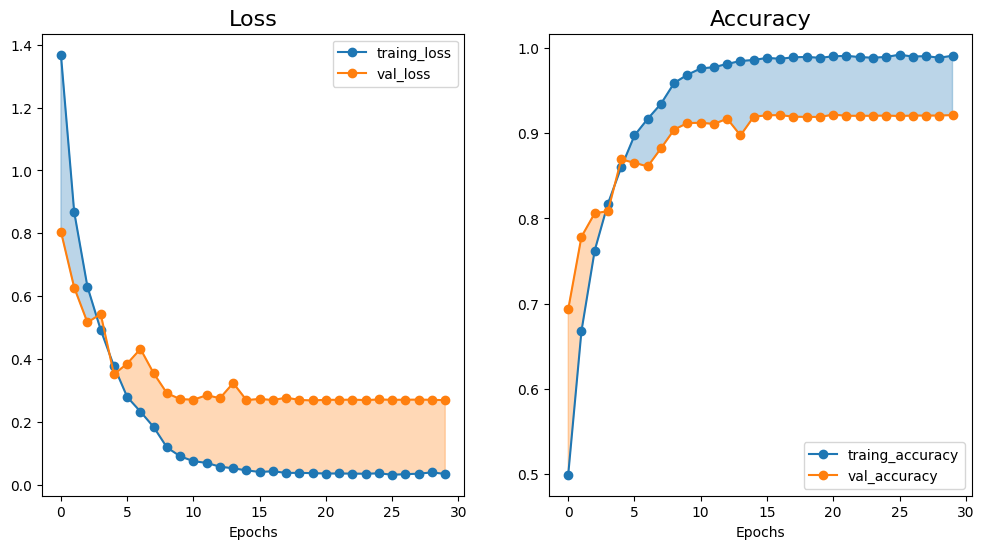

In [13]:
plot_training_curves(history)

In [14]:
y_pred_probs = model.predict(x_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)

118/118 [==============================] - 1s 9ms/step


In [15]:
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix,
    f1_score,
)

In [16]:
conf_matrix = confusion_matrix(y_true, y_pred)
accuracy = accuracy_score(y_true, y_pred)
precision = precision_score(y_true, y_pred, average="weighted")
recall = recall_score(y_true, y_pred, average="weighted")
f1 = f1_score(y_true, y_pred, average="weighted")
print(f"Accuracy: {accuracy}")
print(f"Precision: {precision}")
print(f"Recall: {recall}")
print(f"F1 Score: {f1}")

Accuracy: 0.9229543039319873
Precision: 0.9225280550055416
Recall: 0.9229543039319873
F1 Score: 0.9223240301916438


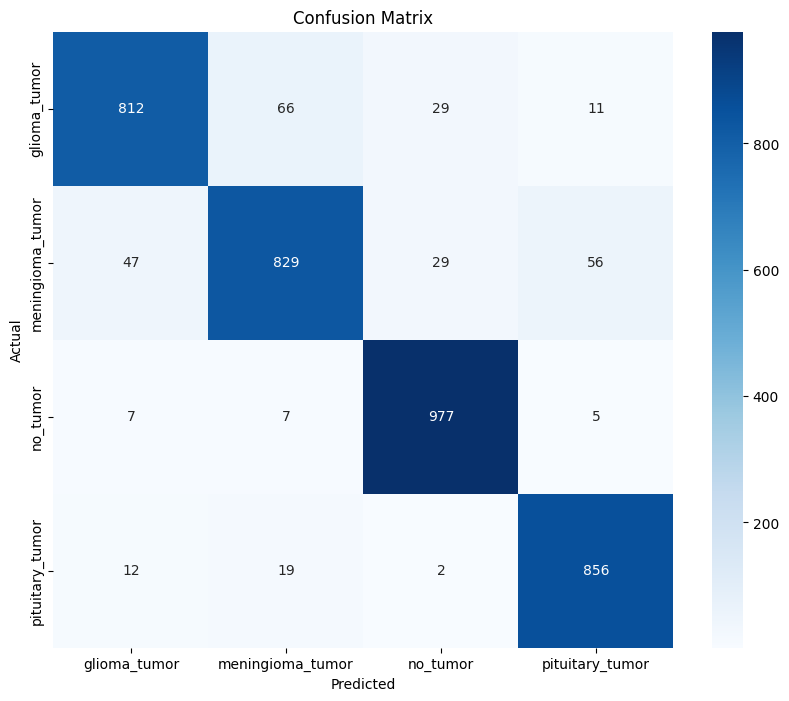

In [17]:
import seaborn as sns

plt.figure(figsize=(10, 8))
sns.heatmap(
    conf_matrix,
    annot=True,
    fmt="d",
    cmap="Blues",
    xticklabels=lb.classes_,
    yticklabels=lb.classes_,
)
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [18]:
model_directory = "Models"
if not os.path.exists(model_directory):
    os.makedirs(model_directory)
model_path = os.path.join(model_directory, "Custom_CNN_03(150x150).h5")
model.save(model_path)
print(f"Model saved to {model_path}")

Model saved to Models\Custom_CNN_03(150x150).h5
